In [2]:
from implicit_learning.trainer import PoissonTrainer 
from implicit_learning.model import  Siren
from implicit_learning.dataset import PoissonEqn
from implicit_learning.utils import *
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torch.utils.data import DataLoader 

import torch
import matplotlib.pyplot as plt 
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [3]:
def construct_dataloader(config):
    sidelength = config['sidelength']
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])

    train = PoissonEqn(config, transform=transform)
    valid = PoissonEqn(config, transform=transform)
    test  = PoissonEqn(config, transform=transform)
    
    train_dataloader =  DataLoader(train, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)
    valid_datalodaer =  DataLoader(valid, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)
    test_dataloader =   DataLoader(test, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)

    return train_dataloader, valid_datalodaer, test_dataloader

class CustomizeTrainer(PoissonTrainer):
    def __init__(self, model, train_dataloader, valid_dataloader, test_dataloader, config, beta=0.8):
        self.lr = config.get("lr")
        super().__init__(model, train_dataloader, valid_dataloader, test_dataloader, config)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.print_epoch = config.get("print_epoch")
        self.sidelength = config.get("sidelength")

        self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer,
                                        lr_lambda=lambda epoch: 1/(1000+((epoch))),
                                        last_epoch=-1,
                                        verbose=False)
        self.beta = beta 

    def train(self):
        for epoch in range(self.epochs):
            inputs = self.model_input

            self.optimizer.zero_grad() 
            outputs, coords =self.model(inputs)
            edge_loss = self.compute_loss(outputs, coords)
            pixel_loss = self.compute_loss2(outputs, coords)
            self.loss = (1- self.beta) * edge_loss + self.beta * pixel_loss

            if epoch %  self.print_epoch == 0:
                print("Epoch %4d"%(epoch), f" : Loss : {self.loss}")
                print(self.beta, pixel_loss.item(), edge_loss.item())
                img_grad = gradient(outputs, coords)
                self.plot(outputs, self.gt['pixels'], img_grad, self.gt)

            self.loss.backward()
            self.optimizer.step()
            self.scheduler.step()

    def compute_loss(self, outputs, coords):
        train_loss = self.gradients_mse(outputs, coords, self.gt['grads'])
        return train_loss 

    def compute_loss2(self, outputs, coords):
        train_loss = ((outputs - self.gt['pixels'])**2).mean()
        return train_loss


    def gradients_mse(self, model_output, coords, gt_gradients):
        # compute gradients on the model
        gradients = gradient(model_output, coords)
        
        gradients_loss = torch.mean((gradients - gt_gradients).pow(2).sum(-1))
        return gradients_loss

    def plot(self, model_output, original, img_grad, gt):
        fig, axes = plt.subplots(1, 4, figsize=(8, 3))
        axes[0].imshow(model_output.cpu().view(self.sidelength,self.sidelength).detach().numpy())
        axes[1].imshow(original.cpu().view(self.sidelength,self.sidelength).detach().numpy(), vmin=0.5-1, vmax=0.5+1)
        axes[2].imshow(img_grad.cpu().norm(dim=-1).view(self.sidelength,self.sidelength).detach().numpy(), vmin=0.5-1, vmax=0.5+1)
        axes[3].imshow(gt['grads'].cpu().norm(dim=-1).view(self.sidelength,self.sidelength).detach().numpy(), vmin=0.5-1, vmax=0.5+1)
        # -----------------------------------------------
        
        plt.figure()
        temp = model_output
        temp2 = temp.flatten().cpu().detach().numpy()
        x = plt.hist(temp2, bins=200,log=True)

        temp = gt['pixels'].cpu()
        temp2 = temp.flatten().cpu().detach().numpy()
        x = plt.hist(temp2, bins=200,log=True)
        plt.legend(["model", "ground truth"])

        plt.figure()
        temp = img_grad.view(1, self.sidelength, self.sidelength,2)
        temp2 = temp[:,:,:,0].flatten().cpu().detach().numpy()
        x = plt.hist(temp2, bins=200,log=True)

        temp = gt['grads'].cpu().view(1, self.sidelength, self.sidelength,2)
        temp2 = temp[:,:,:,0].flatten().cpu().detach().numpy()
        x = plt.hist(temp2, bins=200,log=True)
        plt.legend(["model", "ground truth"])
        
        plt.show()

Epoch    0  : Loss : 1.094792127609253
1.0 1.094792127609253 93.97116088867188


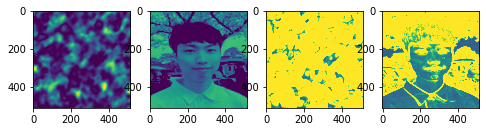

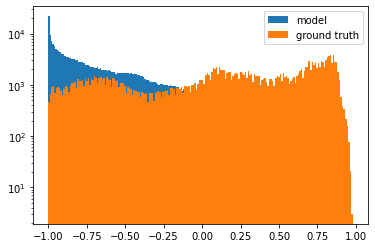

In [4]:

config = {
    "model":{
        "in_features":2,
        "hidden_features":80,
        "hidden_layers":5,
        "out_features":1
    },
    "sidelength":512,
    "epochs":1000,
    "lr":0.1,
    "batch_size":1,
    "data-path":"../../data/cwkanghigh.jpg",
    "print_epoch":1000
}

model = Siren(**config['model'])
model.cuda()
trainer = CustomizeTrainer(model, *construct_dataloader(config), config, beta=1.0)

trainer.train()

In [ ]:
model_input = trainer.model_input 
image = trainer.model.forward(model_input)
for b in np.linspace(-1,1,1):
    temp = image[0] + b 
    temp = temp.reshape(trainer.sidelength, trainer.sidelength).detach().cpu().numpy()
    plt.figure()
    plt.imshow(temp)

truth  = trainer.gt['pixels'].detach().cpu().numpy().reshape(config.get("sidelength"),config.get("sidelength"))
plt.figure()
plt.imshow(truth)

temp = temp - temp.mean() +4
truth = truth - truth.mean()


from mpl_toolkits.mplot3d import Axes3D
x, y = np.meshgrid(range(config.get("sidelength")), range(config.get("sidelength")))
fig = plt.figure(figsize=(100,100))
ax = fig.add_subplot(111, projection='3d', )


ax.plot_surface(x,y, truth, rstride=1, cstride=1,
                cmap='winter', edgecolor='none', alpha=0.3)

ax.plot_surface(x,y, temp, rstride=1, cstride=1,
                cmap='winter', edgecolor='none', alpha=0.3)

NameError: name 'trainer' is not defined